# Kestrel+Model
### A [Bangkit 2021](https://grow.google/intl/id_id/bangkit/) Capstone Project

Kestrel is a TensorFlow powered American Sign Language translator Android app that will make it easier for anyone to seamlessly communicate with people who have hearing impairments. The Kestrel model builds on the state of the art MobileNetV2 model that is optimized for speed and latency on smartphones to accurately recognize and interpret sign language from the phone’s camera and display the translation through a beautiful, convenient and easily accessible Android app.

# American Sign Language 
Fingerspelling alphabets
from the [National Institute on Deafness and Other Communication Disorders (NIDCD)](https://www.nidcd.nih.gov/health/american-sign-language-fingerspelling-alphabets-image) 

<table>
  <tr><td>
    <img src="https://www.nidcd.nih.gov/sites/default/files/Content%20Images/NIDCD-ASL-hands-2019_large.jpg"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://www.nidcd.nih.gov/health/american-sign-language-fingerspelling-alphabets-image">ASL Fingerspelling Alphabets</a> <br/>&nbsp;
  </td></tr>
</table>

# (Optional) Mount from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Initial setup

In [1]:
try:
    %tensorflow_version 2.x
except:
    pass

import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import PIL
import PIL.Image
from os import listdir

import pathlib

from tqdm import tqdm
from tensorflow.keras.preprocessing import image_dataset_from_directory

print("\u2022 Using TensorFlow Version:", tf.__version__)
print("\u2022 Using TensorFlow Hub Version: ", hub.__version__)
print('\u2022 GPU Device Found.' if tf.config.list_physical_devices('GPU') else '\u2022 GPU Device Not Found. Running on CPU')


• Using TensorFlow Version: 2.4.1
• Using TensorFlow Hub Version:  0.9.0
• GPU Device Found.


# Data preprocessing

### Loading images from directory

In [2]:
data_dir = pathlib.Path('/Dev/fingerspelling5/dataset5/Combined')

### (Optional) Counting the number of images in the dataset

In [ ]:
image_count = len(list(data_dir.glob('*/color*.png')))
print(image_count)

65774


### (Optional) Displaying one of the "a" letter sign language image:

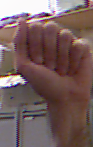

In [ ]:
two = list(data_dir.glob('*/color*.png'))
PIL.Image.open(str(two[2]))

# Create the dataset

Loading the images off disk using [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory). Define some parameters for the loader:

In [3]:
BATCH_SIZE = 30
IMG_SIZE = (128, 128)

### Coursera method using ImageDataGenerator

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
      validation_split=0.2)
validation_generator = ImageDataGenerator(
      rescale = 1./255,
      validation_split=0.2)
train_dataset = train_generator.flow_from_directory(data_dir,
                                                    batch_size = BATCH_SIZE,
                                                    class_mode = 'categorical',
                                                    subset='training', 
                                                    target_size = IMG_SIZE,
                                                    shuffle=True,
                                                    )
validation_dataset = validation_generator.flow_from_directory(data_dir,
                                                    batch_size = BATCH_SIZE,
                                                    class_mode = 'categorical',
                                                    subset='validation', 
                                                    target_size = IMG_SIZE,
                                                    shuffle=True,
                                                    )

Found 52629 images belonging to 24 classes.
Found 13145 images belonging to 24 classes.


# Create the model

### Create the base model from the pre-trained convnets 
We will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify the fingerspelling alphabets from our specific dataset.

First, we need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful.  Instead, we will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [5]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3),
                                               include_top=False,
                                               weights='imagenet')

This feature extractor converts each `128 x 128` image into a `4x4x1280` block of features. Let's see what it does to an example batch of images:

In [6]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(30, 4, 4, 1280)


### Freeze the convolutional base
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [7]:
base_model.trainable = False

In [8]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

### Adding new layer to the model

In [9]:
last_layer = base_model.get_layer('out_relu')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 4, 4, 1280)


### Keras Tuner

The Keras Tuner is a library that helps us to pick the optimal set of hyperparameters for our TensorFlow program. The process of selecting the right set of hyperparameters for your machine learning (ML) application is called *hyperparameter tuning* or *hypertuning*.

Hyperparameters are the variables that govern the training process and the topology of an ML model. These variables remain constant over the training process and directly impact the performance of your ML program. Hyperparameters are of two types:
1. **Model hyperparameters** which influence model selection such as the number and width of hidden layers
2. **Algorithm hyperparameters** which influence the speed and quality of the learning algorithm such as the learning rate for Stochastic Gradient Descent (SGD) and the number of nearest neighbors for a k Nearest Neighbors (KNN) classifier

In this project, we will use the Keras Tuner to perform hypertuning for an image classification application.

In [10]:
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from tensorflow.keras import Model
!pip install -q -U keras-tuner
import kerastuner as kt

### Define the model

When we build a model for hypertuning, we also define the hyperparameter search space in addition to the model architecture. The model we set up for hypertuning is called a *hypermodel*.

We can define a hypermodel through two approaches:

* By using a model builder function
* By subclassing the `HyperModel` class of the Keras Tuner API

We can also use two pre-defined `HyperModel` classes - [HyperXception](https://keras-team.github.io/keras-tuner/documentation/hypermodels/#hyperxception-class) and [HyperResNet](https://keras-team.github.io/keras-tuner/documentation/hypermodels/#hyperresnet-class) for computer vision applications.

In this project, we use a model builder function to define the image classification model. The model builder function returns a compiled model and uses hyperparameters we define inline to hypertune the model.

In [11]:
def model_builder(hp):
  # Flatten the output layer to 1 dimension
  x = layers.Flatten()(last_output)
  # Add a fully connected layer with 1,024 hidden units and ReLU activation
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  x = layers.Dense(units=hp_units, activation='relu')(x)
  # Add a dropout rate of 0.2
  # x = layers.Dropout(0.2)(x)                  
  # Add a final layer for classification
  x = layers.Dense  (24, activation='softmax')(x)           
  model = Model( base_model.input, x) 

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=hp_learning_rate, name="RMSprop"),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

  return model

## Instantiate the tuner and perform hypertuning

Instantiate the tuner to perform the hypertuning. The Keras Tuner has four tuners available - `RandomSearch`, `Hyperband`, `BayesianOptimization`, and `Sklearn`. In this project, we use the [Hyperband](https://arxiv.org/pdf/1603.06560.pdf) tuner.

To instantiate the Hyperband tuner, we must specify the hypermodel, the `objective` to optimize and the maximum number of epochs to train (`max_epochs`).

In [12]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='keras_tuner',
                     project_name='1_Max50Tuner')

INFO:tensorflow:Reloading Oracle from existing project keras_tuner\1_Max50Tuner\oracle.json
INFO:tensorflow:Reloading Tuner from keras_tuner\1_Max50Tuner\tuner0.json


The Hyperband tuning algorithm uses adaptive resource allocation and early-stopping to quickly converge on a high-performing model. This is done using a sports championship style bracket. The algorithm trains a large number of models for a few epochs and carries forward only the top-performing half of models to the next round. Hyperband determines the number of models to train in a bracket by computing 1 + log<sub>`factor`</sub>(`max_epochs`) and rounding it up to the nearest integer.

Create a callback to stop training early after reaching a certain value for the validation loss.

In [13]:
early_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        # Stop training when `val_accuracy` is no longer improving
        monitor="val_accuracy",
        # "no longer improving" being further defined as "for at least 5 epochs"
        patience=5,
        verbose=1,
    )
]

Run the hyperparameter search. The arguments for the search method are the same as those used for `tf.keras.model.fit` in addition to the callback above.

In [14]:
tuner.search(train_dataset, epochs=50, validation_data = validation_dataset, verbose = 1, callbacks=[early_callbacks])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 4 Complete [00h 39m 43s]
val_accuracy: 0.04724229872226715

Best val_accuracy So Far: 0.7180677056312561
Total elapsed time: 04h 31m 39s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 448 and the optimal learning rate for the optimizer
is 0.0001.



In [15]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(448, activation='relu')(x)
# Add a dropout rate of 0.2
# x = layers.Dropout(0.2)(x)                  
# Add a final layer for classification
x = layers.Dense  (24, activation='softmax')(x)           

model = Model( base_model.input, x) 
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [ ]:
# install scipy if needed
# !pip install scipy

### Training the model

In [16]:
checkpoint_path = "TensorFlow_Training_Checkpoint/Kestrel_Training_16_Max50New/cp.ckpt"

Find the optimal number of epochs to train the model with the hyperparameters obtained from the search.

In [17]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_dataset, epochs=50, validation_data = validation_dataset, verbose = 1)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
1755/1755 [==============================] - 331s 186ms/step - loss: 1.7845 - accuracy: 0.4903 - val_loss: 1.3897 - val_accuracy: 0.6070
Epoch 2/50
1755/1755 [==============================] - 463s 264ms/step - loss: 0.8803 - accuracy: 0.7280 - val_loss: 1.2572 - val_accuracy: 0.6577
Epoch 3/50
1755/1755 [==============================] - 666s 379ms/step - loss: 0.7017 - accuracy: 0.7792 - val_loss: 1.2224 - val_accuracy: 0.6834
Epoch 4/50
1755/1755 [==============================] - 638s 363ms/step - loss: 0.6357 - accuracy: 0.8002 - val_loss: 1.3073 - val_accuracy: 0.6877
Epoch 5/50
1755/1755 [==============================] - 565s 322ms/step - loss: 0.5742 - accuracy: 0.8234 - val_loss: 1.5494 - val_accuracy: 0.6749
Epoch 6/50
1755/1755 [==============================] - 708s 403ms/step - loss: 0.5414 - accuracy: 0.8336 - val_loss: 1.4084 - val_accuracy: 0.6976
Epoch 7/50
1755/1755 [==============================] - 553s 315ms/step - loss: 0.5179 - accuracy: 0.8404 - val_

### Plotting the accuracy and loss

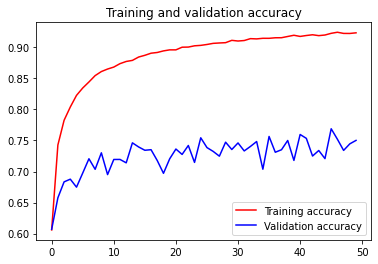

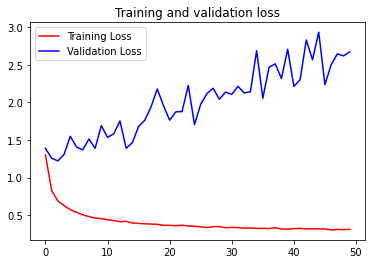

In [18]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
import os
# base_learning_rate = 0.0001
def get_uncompiled_model():
    model = Model( base_model.input, x) 
    return model

def get_compiled_model():
    model = get_uncompiled_model()
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.1),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

checkpoint_dir = os.path.dirname(checkpoint_path)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

def make_or_restore_model():
    # Either restore the latest model, or create a fresh one
    # if there is no checkpoint available.
    checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        print("Restoring from", latest_checkpoint)
        # Used if restoring from full model
        # return tf.keras.models.load_model(latest_checkpoint) 
        # Used if restoring from weights only
        model = Model( base_model.input, x) 
        model.load_weights(checkpoint_path)
        model.compile(
        optimizer="rmsprop",
        loss="categorical_crossentropy",
        metrics=["accuracy"],
        )
        return model
    print("Creating a new model")
    return get_compiled_model()

# Create a callback that saves the model's weights
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 monitor='val_accuracy',
                                                 mode='auto',
                                                 save_best_only=True, # Only save a model if `val_loss` has improved.
                                                 verbose=1)

early_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_accuracy",
        # "no longer improving" being defined as "no better than 1e-2 less"
        # min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=10,
        verbose=1,
    )
]

model = make_or_restore_model()
history = model.fit(train_dataset, 
                    epochs=40, 
                    validation_data = validation_dataset, 
                    verbose = 1, 
                    callbacks=[model_checkpoint_callback, early_callbacks])# Pass callback to training

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

# # EXERCISE: Use the tf.saved_model API to save your model in the SavedModel format. 
# export_dir = 'saved_model/2'

# # YOUR CODE HERE
# tf.saved_model.save(model, export_dir)

Creating a new model
Epoch 1/40
1755/1755 [==============================] - 666s 377ms/step - loss: 7.3148 - accuracy: 0.3793 - val_loss: 1.7034 - val_accuracy: 0.5547

Epoch 00001: val_accuracy improved from -inf to 0.55474, saving model to TensorFlow_Training_Checkpoint/Kestrel_Training_15_Max50\cp.ckpt
Epoch 2/40
1755/1755 [==============================] - 842s 480ms/step - loss: 1.2515 - accuracy: 0.6235 - val_loss: 1.8110 - val_accuracy: 0.5626

Epoch 00002: val_accuracy improved from 0.55474 to 0.56257, saving model to TensorFlow_Training_Checkpoint/Kestrel_Training_15_Max50\cp.ckpt
Epoch 3/40
1755/1755 [==============================] - 829s 472ms/step - loss: 1.1911 - accuracy: 0.6515 - val_loss: 1.6228 - val_accuracy: 0.5879

Epoch 00003: val_accuracy improved from 0.56257 to 0.58790, saving model to TensorFlow_Training_Checkpoint/Kestrel_Training_15_Max50\cp.ckpt
Epoch 4/40
1755/1755 [==============================] - 804s 458ms/step - loss: 1.1925 - accuracy: 0.6640 - val_

# Exporting to TFLite
You will now save the model to TFLite. We should note, that you will probably see some warning messages when running the code below. These warnings have to do with software updates and should not cause any errors or prevent your code from running. 


In [19]:
# EXERCISE: Use the tf.saved_model API to save your model in the SavedModel format. 
export_dir = 'saved_model/13_Max50'

# YOUR CODE HERE
tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: saved_model/13_Max50\assets


In [ ]:
# # Select mode of optimization
# mode = "Speed" 

# if mode == 'Storage':
#     optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
# elif mode == 'Speed':
#     optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
# else:
#     optimization = tf.lite.Optimize.DEFAULT

In [20]:
# EXERCISE: Use the TFLiteConverter SavedModel API to initialize the converter
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir) # YOUR CODE HERE

# Set the optimzations
converter.optimizations = [tf.lite.Optimize.DEFAULT]# YOUR CODE HERE

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()# YOUR CODE HERE

In [21]:
tflite_model_file = pathlib.Path('saved_model/13_Max50/model.tflite')
tflite_model_file.write_bytes(tflite_model)

11815104

In [ ]:
# path_to_pb = "C:/saved_model/saved_model.pb"
# def load_pb(path_to_pb):
#     with tf.gfile.GFile(path_to_pb, "rb") as f:
#         graph_def = tf.GraphDef()
#         graph_def.ParseFromString(f.read())
#     with tf.Graph().as_default() as graph:
#         tf.import_graph_def(graph_def, name='')
#         return graph
#         print(graph)

# Test the model with TFLite interpreter

In [ ]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [ ]:
# Gather results for the randomly sampled test images
predictions = []
test_labels = []
test_images = []
test_batches = data_dir.map(format_example).batch(1)
for img, label in test_batches.take(50):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    test_labels.append(label[0])
    test_images.append(np.array(img))

AttributeError: ignored

In [ ]:
# Utilities functions for plotting

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label.numpy():
        color = 'green'
    else:
        color = 'red'
        
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]),
                                         color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks(list(range(10)))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array[0], color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array[0])
    
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

In [ ]:
# Visualize the outputs

# Select index of image to display. Minimum index value is 1 and max index value is 50. 
index = 5 

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(index, predictions, test_labels)
plt.show()